# Consensus Peak Set

**Created**: 10 November 2021

## Environment

In [1]:
if (!require("Rtsne")) {
    install.packages("Rtsne")
}

if (!require("UpSetR")) {
    install.packages("UpSetR")
}

if (!requireNamespace("patchwork")) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

Loading required package: Rtsne

Loading required package: UpSetR

Loading required namespace: patchwork



In [2]:
library(tidyverse)
library(data.table)
library(RColorBrewer)
library(Rtsne)
library(UpSetR)
library(patchwork)

setwd("~/eQTL_pQTL_Characterization/")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




## Load Data

In [3]:
ia.consensus.peak.set <- fread("~/gains_team282/epigenetics/accessibility/analysis/atac_seq/immune/consensus_peaks.bed")
colnames(ia.consensus.peak.set) <- c("Chr", "Start", "End", "Peak.ID", "Strand")

In [4]:
head(ia.consensus.peak.set)

Chr,Start,End,Peak.ID,Strand
<chr>,<int>,<int>,<chr>,<chr>
1,804821,805016,1:804821-805016,.
1,812642,812879,1:812642-812879,.
1,815224,815554,1:815224-815554,.
1,817057,817622,1:817057-817622,.
1,819712,820327,1:819712-820327,.
1,821473,823221,1:821473-823221,.


In [5]:
rm.consensus.peak.set <- fread("~/gains_team282/epigenetics/accessibility/analysis/atac_seq/neutrophil/consensus_peaks.bed")
colnames(rm.consensus.peak.set) <- c("Chr", "Start", "End", "Peak.ID", "Strand")

In [6]:
head(rm.consensus.peak.set)

Chr,Start,End,Peak.ID,Strand
<chr>,<int>,<int>,<chr>,<chr>
1,827317,827808,1:827317-827808,.
1,869784,870190,1:869784-870190,.
1,904630,904875,1:904630-904875,.
1,913022,913344,1:913022-913344,.
1,913595,914626,1:913595-914626,.
1,918473,919352,1:918473-919352,.


In [7]:
sample.info <- read.csv("03_Functional_Interpretation/metadata/reads_atac_seq.txt")
rownames(sample.info) <- sample.info$Run
sample.info <- sample.info %>%
    dplyr::select(Run, Donor, Cell.Type=Cell_type, Lineage, Treatment) %>%
    dplyr::mutate(Donor=factor(Donor), Cell.Type=factor(Cell.Type), Lineage=factor(Lineage)) %>%
    dplyr::mutate(Treatment=recode(Treatment, no_treament="No_Treatment", treatment1="Treatment_1", treatment2="Treatment_2"))

In [8]:
head(sample.info)

,Run,Donor,Cell.Type,Lineage,Treatment
,<chr>,<fct>,<fct>,<fct>,<chr>
SRR2920475,SRR2920475,Corces-4983,Monocytes,MYELOID,Control
SRR2920488,SRR2920488,Corces-6792,Monocytes,MYELOID,Control
SRR2920476,SRR2920476,Corces-4983,Monocytes,MYELOID,Control
SRR2920487,SRR2920487,Corces-6792,Monocytes,MYELOID,Control
SRR2920542,SRR2920542,Corces-7256,Monocytes,MYELOID,Control
SRR2920543,SRR2920543,Corces-7256,Monocytes,MYELOID,Control


In [9]:
chr.lengths <- read.table("~/gains_team282/epigenetics/star_genome_index/chrNameLength.txt")
colnames(chr.lengths) <- c("Chr", "Chr.Length")
rownames(chr.lengths) <- chr.lengths$Chr

In [10]:
head(chr.lengths)

,Chr,Chr.Length
,<chr>,<int>
1,1,248956422
10,10,133797422
11,11,135086622
12,12,133275309
13,13,114364328
14,14,107043718


## General Summary

There are $n=296994$ peaks in the final set of the immune atlas. There are $n=58793$ in the final set of the neutrophil atlas.

In [11]:
nrow(ia.consensus.peak.set)

[1] 296994

In [12]:
nrow(rm.consensus.peak.set)

[1] 140923

## Peaks per Chromosome

To see if there is a bias for certain chromosomes over other, I calculate the number of peaks per Mb of the chromosome. The data looks relatively consistent other than the Y chromosome, where few peaks were counted.

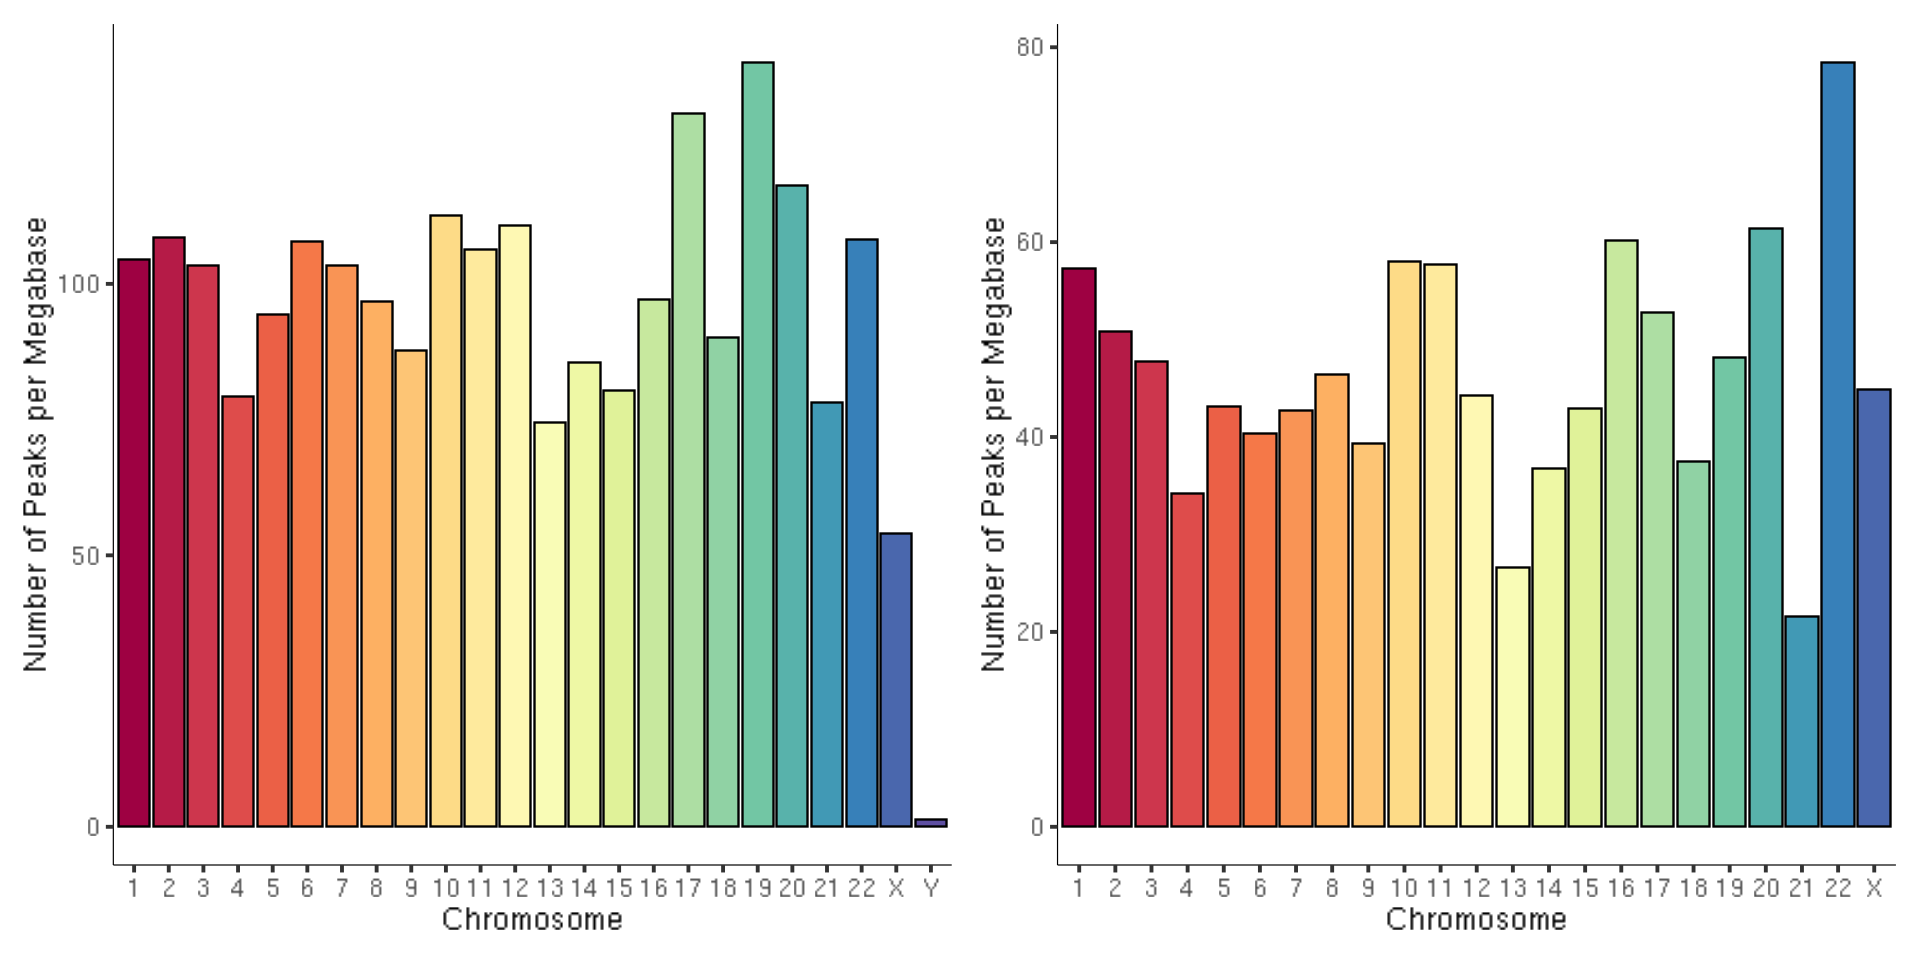

In [13]:
options(repr.plot.width=16, repr.plot.height=8)

p1 <- ia.consensus.peak.set %>%
    as.data.frame() %>%
    dplyr::group_by(Chr) %>%
    dplyr::summarize(N.Peaks=n()) %>%
    dplyr::filter(Chr %in% c(1:22, "X", "Y")) %>%
    dplyr::mutate(Chr=factor(Chr, levels=c(1:22, "X", "Y"))) %>%
    merge(., chr.lengths, by="Chr") %>%
    dplyr::mutate(Normalized.N.Peaks=N.Peaks / Chr.Length * 10^6) %>%
    ggplot() +
    geom_bar(aes(x=Chr, y=Normalized.N.Peaks, fill=Chr), color="black", stat="identity") +
    scale_fill_manual(values=colorRampPalette(brewer.pal(11, "Spectral"))(24)) +
    xlab("Chromosome") + ylab("Number of Peaks per Megabase") +
    guides(fill="none") +
    ggplot_theme

p2 <- rm.consensus.peak.set %>%
    as.data.frame() %>%
    dplyr::group_by(Chr) %>%
    dplyr::summarize(N.Peaks=n()) %>%
    dplyr::filter(Chr %in% c(1:22, "X", "Y")) %>%
    dplyr::mutate(Chr=factor(Chr, levels=c(1:22, "X", "Y"))) %>%
    merge(., chr.lengths, by="Chr") %>%
    dplyr::mutate(Normalized.N.Peaks=N.Peaks / Chr.Length * 10^6) %>%
    ggplot() +
    geom_bar(aes(x=Chr, y=Normalized.N.Peaks, fill=Chr), color="black", stat="identity") +
    scale_fill_manual(values=colorRampPalette(brewer.pal(11, "Spectral"))(24)) +
    xlab("Chromosome") + ylab("Number of Peaks per Megabase") +
    guides(fill="none") +
    ggplot_theme

p1 + p2

ggsave("03_Functional_Interpretation/results/consensus_peaks_per_chromosome.svg", width=16, height=8)

## Peak Width

The peak size was restricted to below 3 kb. Any intersecting peaks that formed broad peaks (> 3 kb) should be pruned. The median peak size is 430. The distribution is skewed to the right, but in general the number of peaks approaching 3 kb is pretty small.

In [14]:
ia.peak.width.data <- ia.consensus.peak.set %>%
    as.data.frame() %>%
    dplyr::mutate(Peak.Size=End-Start+1)
median(ia.peak.width.data$Peak.Size)

[1] 555

In [15]:
rm.peak.width.data <- rm.consensus.peak.set %>%
    as.data.frame() %>%
    dplyr::mutate(Peak.Size=End-Start+1)
median(rm.peak.width.data$Peak.Size)

[1] 523

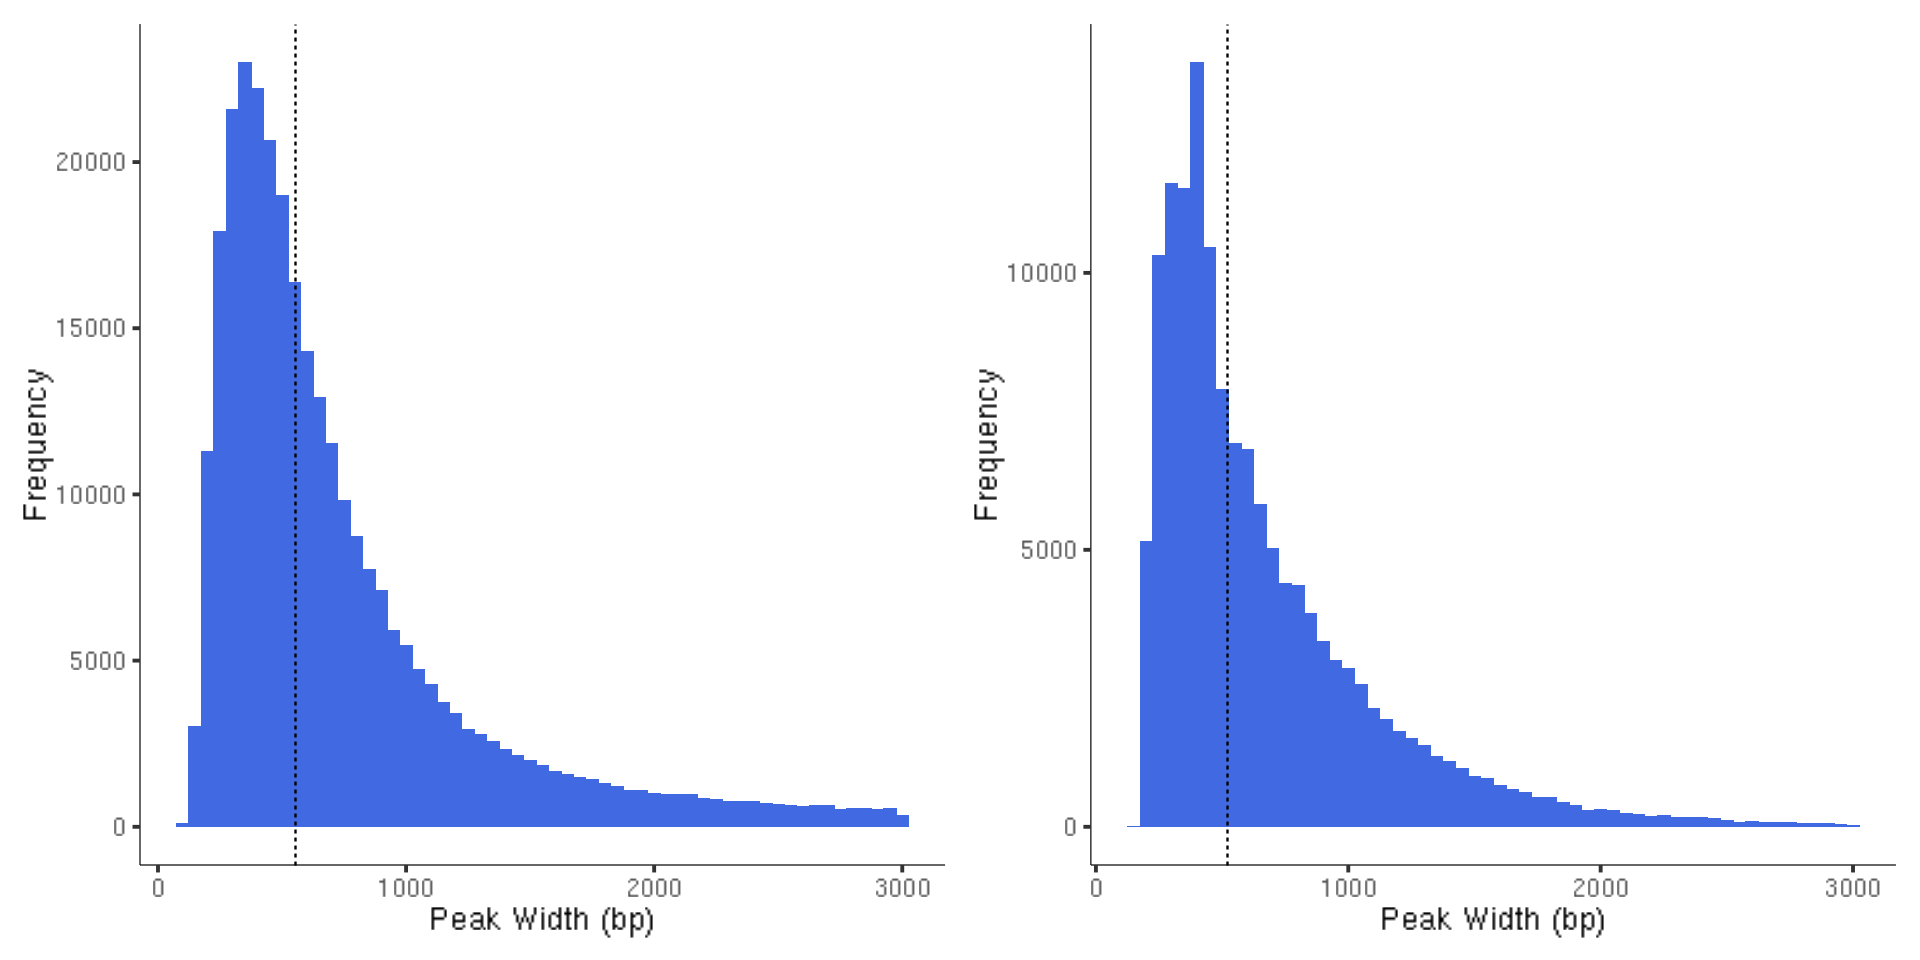

In [16]:
options(repr.plot.width=16, repr.plot.height=8)

p1 <- ia.peak.width.data %>%
    ggplot() +
    geom_histogram(aes(x=Peak.Size), binwidth=50, fill="royalblue") +
    geom_vline(xintercept=median(ia.peak.width.data$Peak.Size), lty=2) +
    xlab("Peak Width (bp)") + ylab("Frequency") +
    ggplot_theme

p2 <- rm.peak.width.data %>%
    ggplot() +
    geom_histogram(aes(x=Peak.Size), binwidth=50, fill="royalblue") +
    geom_vline(xintercept=median(rm.peak.width.data$Peak.Size), lty=2) +
    xlab("Peak Width (bp)") + ylab("Frequency") +
    ggplot_theme

p1 + p2

ggsave("03_Functional_Interpretation/results/consensus_peaks_peak_width.svg", width=16, height=8)